1\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn!):

* Fill a numpy array, x,  of len(N) (with N=O(100)) with a variable normally distributed, with a given mean a standard deviation
* Fill an histogram in pyplot taking properly care about the aesthetic
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* for every element of x, create a gaussian with the mean corresponding the element value and std as a parameter that can be tuned. The std default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5.}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with np.sum()) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.integrate import trapz
%matplotlib inline

The Kernel Density Estimate of a given discrete probability function is given by:
$$
    f(x) = \frac{1}{N} \sum_{i=1}^{N} K\left(\frac{x - x_i}{h}\right)
$$
where $N$ is the number of data points, $K$ is the desired kernel function which in our case is given by ```scipi.stats.norm``` method in this fashion:

```K(z; x_i, h) = norm(loc=x_i, scale=h).pdf(z)```

where $z$ is a point on a grid, $x_i$ is the i-th element of the initial discrete pdf (i.e. the bin-content of a properly normalized-to-1 histogram) and h is the standard deviation. $K$ is in fact:
$$
    K(z; x_i, h) = \frac{1}{h\sqrt{2\pi}} \cdot \exp\left(- \frac{(z - x_i)^2}{2 h^2}\right)
$$
and since the individual functions are already normalized to one, their sum will equal $N$. So, in order to properly normalize the KDE to 1, it must be divided by N also.

In [3]:
N = 200
nbins = 8
mean = 0
sigma = 0.4

In [4]:
# generating the data histogram
x = sigma*np.random.randn(N) + mean
binned_data, binEdges = np.histogram(x, bins=nbins)
binCenters = (binEdges[1:]+binEdges[:-1])*0.5
binWidth = (binEdges[1]-binEdges[0])

In [5]:
def my_kde(x_data, grid_padding=0.5, n_grid=100):
    # generating a linear grid
    x_grid = np.linspace(x_data.min()-grid_padding, x_data.max()+grid_padding, n_grid)
    # setting h value
    h = (1.06*x_data.std())*(x_data.size**(-1/5.))
    # ready to generate the kernel functions -> 2-d array with x_data.shape[0] rows and n_grid cols
    kfs = [ norm.pdf(x_grid, loc=x_data[i], scale=h) for i in range(0,x_data.shape[0],1) ]
    # now stacking each pdf ontop of each-other
    kfs = np.vstack(kfs)
    # summing along the columns
    sum_kfs = np.sum(kfs, axis=0)
    return [x_grid, sum_kfs*(1./(x_data.shape[0])), kfs]

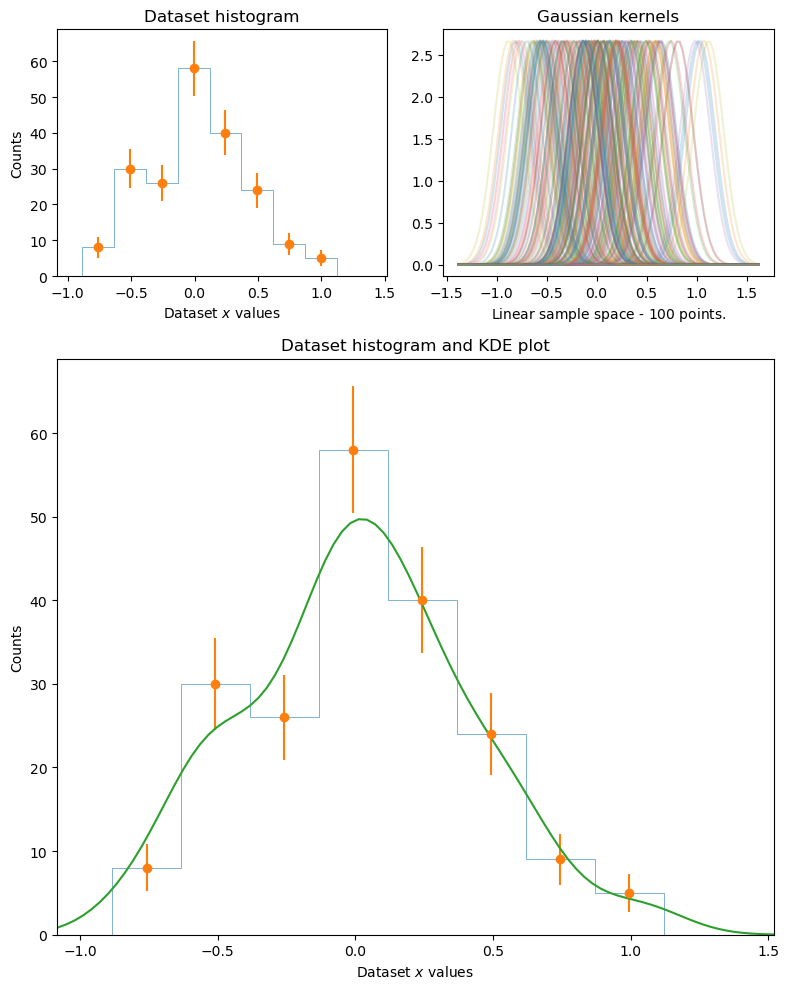

In [16]:
# Displaying results - Non Normalized version
fig = plt.figure(figsize=(8,10))
fig_grid = (2,2)
ax_0 = plt.subplot2grid(shape=(3,2), loc=(0,0), fig=fig)

# plotting the original histogram with no-normalization
ax_0.hist(binEdges[:-1], binEdges, weights=binned_data, histtype='step', lw=0.4)
ax_0.errorbar(binCenters, binned_data, yerr = np.sqrt(binned_data), fmt ='o')
ax_0.set_xlim(left=np.min(binEdges)-0.2, right=np.max(binEdges)+0.4)
ax_0.set_title("Dataset histogram")
ax_0.set_xlabel("Dataset $x$ values")
ax_0.set_ylabel("Counts")

# plotting now all the obtained gaussians which are each normalized to 1 but their sum is not (the sum's integral is N)
ax_1 = plt.subplot2grid(shape=(3,2), loc=(0,1), fig=fig)
n_grid_kde=100
x_grid, y_grid, gaussians = my_kde(x, n_grid=n_grid_kde)
for i in range(gaussians.shape[0]):
    ax_1.plot(x_grid, gaussians[i], alpha=0.2)
ax_1.set_title("Gaussian kernels")
ax_1.set_xlabel("Linear sample space - $"+str(n_grid_kde)+"$ points.")

# plotting again the original non-normalized histogram but this time with the non-normalized KDE on-top to show the estimate
ax_2 = plt.subplot2grid(shape=(3,2), loc=(1,0), rowspan=2, colspan=2, fig=fig)
ax_2.hist(binEdges[:-1], binEdges, weights=binned_data, histtype='step', lw=0.4)
ax_2.errorbar(binCenters, binned_data, yerr = np.sqrt(binned_data), fmt ='o')
ax_2.set_xlim(left=np.min(binEdges)-0.2, right=np.max(binEdges)+0.4)
ax_2.set_xlabel("Dataset $x$ values")
ax_2.set_ylabel("Counts")
ax_2.set_title("Dataset histogram and KDE plot")

# plotting the re-scaled KDE (has to be multiplied by binWidth*N, that is the integral of the original histogram since the KDE is by
# definition normalized to 1.
ax_2.plot(x_grid, y_grid*binWidth*N)

fig.tight_layout()

Text(0, 0.5, 'Counts / (Integral . BinWidth)')

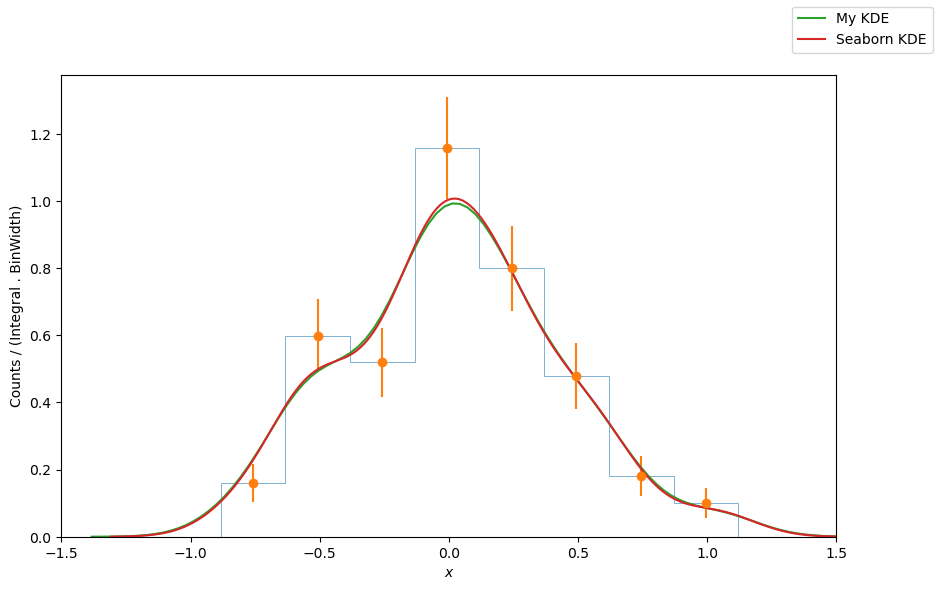

In [17]:
# Displaying results - Normalized version
fig, ax = plt.subplots(figsize=(10,6))
# normalizing the original histogram to 1 to show the density estimate
ax.hist(binEdges[:-1], binEdges, weights=binned_data, density=True, histtype='step', lw=0.4)
norm_hist_data = binned_data / (binWidth*np.sum(binned_data))
ax.errorbar(binCenters, norm_hist_data, yerr = np.sqrt(norm_hist_data/(np.sum(binned_data)*binWidth)), fmt ='o')
# plotting my KDE
x_grid, y_grid, _ = my_kde(x)
ax.plot(x_grid, y_grid, label="My KDE")
# comparison with seaborn's implementation to check if it was alright
import seaborn as sns
sns.kdeplot(x, label="Seaborn KDE")
fig.legend(loc="upper right")
# setting axes
ax.set_xlim(left=-1.5, right=1.5)
ax.set_xlabel("$x$")
ax.set_ylabel("Counts / (Integral . BinWidth)")

Reference: https://towardsdatascience.com/kernel-density-estimation-explained-step-by-step-7cc5b5bc4517

2\. **Color-coded scatter plot**

Produce a scatter plot out of a dataset with two categories

* Write a function that generate a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and std (clearly it is better to have different values means..)
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below

You can try to make the procedure more general by allowing a given number $n\ge 2$ of categories

--2024-01-22 19:13:59--  https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
Resolving www.dropbox.com (www.dropbox.com)... 2620:100:6025:18::a27d:4512, 162.125.69.18
Connecting to www.dropbox.com (www.dropbox.com)|2620:100:6025:18::a27d:4512|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/u4y3k4kk5tc7j46/two_categories_scatter_plot.png [following]
--2024-01-22 19:13:59--  https://www.dropbox.com/s/raw/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
Reusing existing connection to [www.dropbox.com]:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc96743c0a47f82d23e838a5244d.dl.dropboxusercontent.com/cd/0/inline/CL2TIbFpIq4zxFJjsIr6sVe2ZaCJPlIFbtzpDeq1K38nojW30mspnrO89Fom9EtrhrAEL9oYJ3f-8JZAHEJ-ihk2jOJH8q-RINL9gf6BTprGKss1ziS75uY2OqBgyuuEJL8/file# [following]
--2024-01-22 19:14:00--  https://uc96743c0a47f82d23e838a5244d.dl.dropboxusercontent.com/cd/0/inline/CL2TIbFpIq4zxFJjsIr6sVe2ZaCJPlIFbtzpDeq1K38nojW

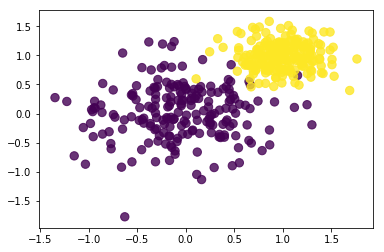

In [18]:
! wget https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
from IPython.display import Image
Image('two_categories_scatter_plot.png')

In [19]:
import pandas as pd

In [20]:
# function that generates a 2D dataset with N categories
def make_data(n_cat=2, cat_labels=[0, 1], cat_prop={0:(0,1), 1:(0,1)}, n_points={0:100, 1:100}):
    # generating a grid of x and y points normally distributed in 2-d space for each category
    df = pd.DataFrame()
    for cat_l in cat_labels:
        rand_x = (cat_prop[cat_l][1]*np.random.randn(n_points[cat_l]))+cat_prop[cat_l][0]
        rand_y = (cat_prop[cat_l][1]*np.random.randn(n_points[cat_l]))+cat_prop[cat_l][0]
        if df.empty:
            df = pd.DataFrame({'x': rand_x, 'y': rand_y, 'label': cat_l})
        else:
            df = pd.concat([df, pd.DataFrame({'x': rand_x, 'y': rand_y, 'label': cat_l})]).reset_index(drop=True)
    # returning the shuffled and re-indexed dataframe
    return df.sample(frac=1).reset_index(drop=True)

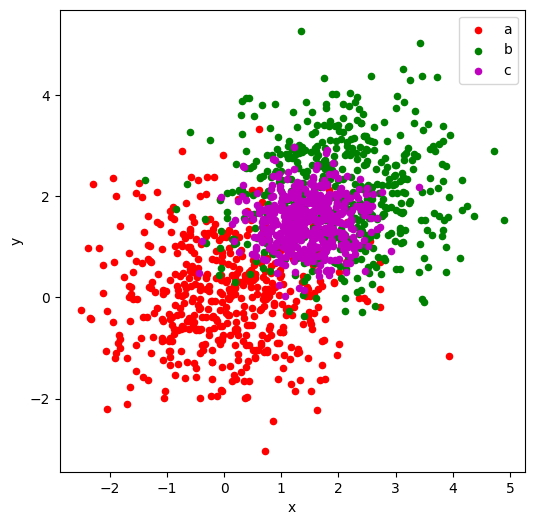

In [10]:
# making some syntetic data
my_data = make_data(cat_labels=["a","b","c"], cat_prop={"a":(0, 1),"b":(2, 1),"c":(1.5,0.5)}, n_points={"a":500,"b":500,"c":500})
# plotting
groups = my_data.groupby('label')

fig, ax = plt.subplots(figsize=(6,6))

colors = {"a":"r","b":"g","c":"m"}
for key, group in groups:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
ax.legend()

Very important: when using groupby, one can access the individual groups in this way.
```
groups = df.groupby('label')
for key, group in groups:
    # then key is the name of the label
    # then group = df[df['label']==key]
```

3\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following dataset and load it as a pandas dataframe:
```bash
wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
```
Note that you should use the `np.load()` function to load the file as a numpy array, call the `.item()` method, and then pass it to the `pd.DataFrame()` constructor.
* Inspect the dataset, you'll find two variables (features)
* Clean the sample by selecting the entries (rows) with the variable "residual" in absolute value smaller than 2
* perform a linear regression of "residuals" versus "distances" using `scipy.stats.linregress()` 
* plot a seaborn jointplot of  "residuals" versus "distances", having seaborn performing a linear regression. The result of the regression should be displayed on the plot
* Fill 3 numpy arrays
  * x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
  * y, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * erry, the standard deviation of the  of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

In [11]:
!wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy

--2024-01-20 15:44:36--  https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
Risoluzione di www.dropbox.com (www.dropbox.com)... 2620:100:6025:18::a27d:4512, 162.125.69.18
Connessione a www.dropbox.com (www.dropbox.com)|2620:100:6025:18::a27d:4512|:443... connesso.
Richiesta HTTP inviata, in attesa di risposta... 302 Found
Posizione: /s/raw/hgnvyj9abatk8g6/residuals_261.npy [segue]
--2024-01-20 15:44:37--  https://www.dropbox.com/s/raw/hgnvyj9abatk8g6/residuals_261.npy
Riutilizzo della connessione esistente a [www.dropbox.com]:443.
Richiesta HTTP inviata, in attesa di risposta... 302 Found
Posizione: https://uc504ba078056e7b8b0f35b0fee7.dl.dropboxusercontent.com/cd/0/inline/CLt_IQw9UF5UpHWYwIz6p9fSd1dG8K2rZxEgYVJYDHJ_qGJ77YO4CSCek1IpJXjn3on6T5v7f9JZlsUoQpeEH5FyvCyzjUIFJjrRjwKP6i3lW9JGrLkabHXsGlOGglnlJ6M/file# [segue]
--2024-01-20 15:44:37--  https://uc504ba078056e7b8b0f35b0fee7.dl.dropboxusercontent.com/cd/0/inline/CLt_IQw9UF5UpHWYwIz6p9fSd1dG8K2rZxEgYVJYDHJ_qGJ77YO4CSCek1IpJXj

In [12]:
data = np.load('residuals_261.npy', allow_pickle=True)
df = pd.DataFrame(data.item())
print(df)

       residuals  distances
0       1.100000       16.0
1      -1.950000        6.3
2      -7.200000        3.4
3      -4.150000        8.4
4      -6.590000        1.7
...          ...        ...
11126  -0.760000       14.4
11127   0.380000        7.5
11128   0.083333        1.7
11129   0.166667       19.1
11130   0.083333        2.6

[11131 rows x 2 columns]


In [13]:
# applying the filter and re-indexing
filt_df = df[df["residuals"].abs() < 2].reset_index(drop=True)

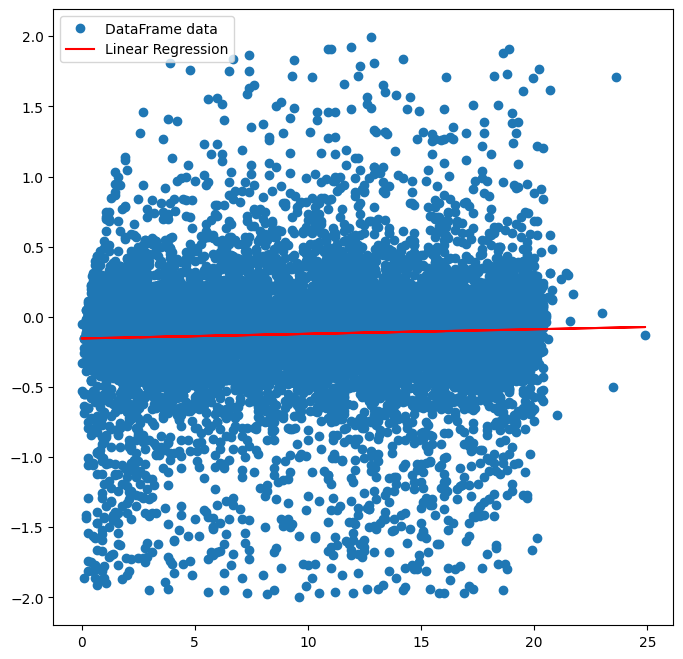

In [14]:
from scipy.stats import linregress
res = linregress(x=filt_df["distances"], y=filt_df["residuals"])

fig, ax = plt.subplots(figsize=(8,8))
ax.plot(filt_df["distances"], filt_df["residuals"], 'o', label='DataFrame data')
ax.plot(filt_df["distances"], res.intercept + res.slope*filt_df["distances"], 'r', label='Linear Regression')
ax.legend(loc='upper left')

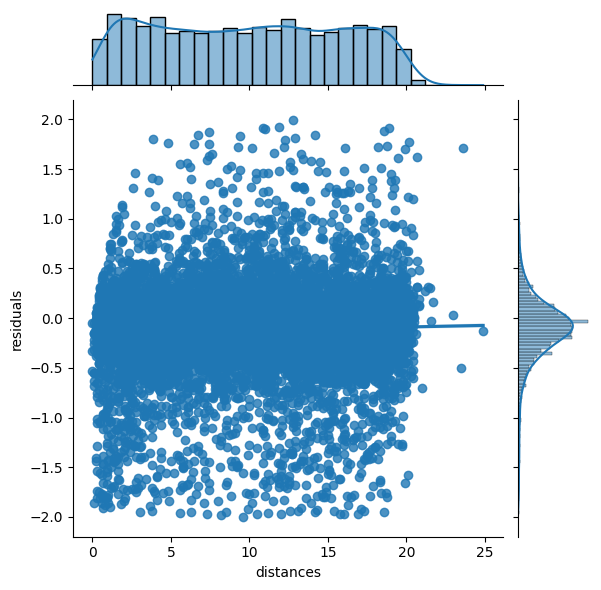

In [15]:
sns.jointplot(filt_df, x="distances", y="residuals", kind="reg")

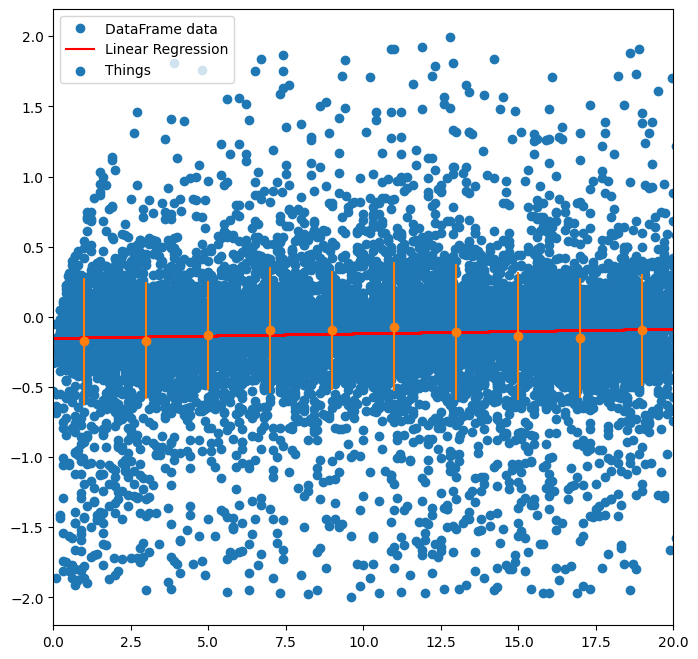

In [16]:
# filling x
counts, binEdges = np.histogram(filt_df["distances"], range=(0,20), bins=10)
x = 0.5*(binEdges[1:] + binEdges[:-1])

# filling y and erry
objs = [ filt_df[(filt_df["distances"] >= binEdges[i-1]) & (filt_df["distances"] < binEdges[i])] for i in range(1,binEdges.shape[0],1) ]
y = np.array([ objs[i]["residuals"].mean() for i in range(len(objs)) ])
erry = np.array([ objs[i]["residuals"].std() for i in range(len(objs)) ])

# plotting profile plot ontop of scatter prlot
fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlim(left=0, right=20)
ax.plot(filt_df["distances"], filt_df["residuals"], 'o', label='DataFrame data')
ax.plot(filt_df["distances"], res.intercept + res.slope*filt_df["distances"], 'r', label='Linear Regression')
ax.scatter(x,y, label='Things')
ax.errorbar(x, y, yerr = erry, fmt ='o')
ax.legend(loc='upper left')
